In [ ]:
! pip install pytorch-lightning --quiet

     |████████████████████████████████| 675kB 5.4MB/s 
     |████████████████████████████████| 829kB 8.3MB/s 
     |████████████████████████████████| 276kB 17.5MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 


Run the following cell (uncommented) for TPU support

In [ ]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy.lib.ufunclike import _deprecate_out_named_y
# neural network packages
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import pytorch_lightning as pl 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import sys
import time
import random
from typing import List, Tuple, Dict, Any
# sklearn
from sklearn import feature_selection
import sklearn.preprocessing
import sklearn.metrics
from sklearn import model_selection

In [ ]:
from google.colab import drive

"""Running this cell will generate a message asking you 
to click on a link where you'll obtain an authorization code.

Paste that authorization code into the text box that appears below.
"""
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cd "/content/gdrive/MyDrive/" && ls # Displays directories in MyDrive/

'Analysis I Chapter 3'	'Colab Notebooks'		       Seminar
 Autodidacticism	 Data				       Sonder
 Brain			 Philosophy-of-Cognitive-Science.pdf   speech_shared
 CML			 School


In [ ]:
dir_path = os.path.join("/content/gdrive/MyDrive/Data", "NNsforGenomics")
os.path.exists(dir_path)

True

In [ ]:
sys.path.append(dir_path)
data_path = os.path.join(dir_path, "data")

In [ ]:
import preprocessing

In [ ]:
class TabularDataset(torch.utils.data.Dataset): # inherit from torch
    def __init__(self, stage: str, X: np.ndarray, Y: np.ndarray):
        assert stage in ["train", "val", "test"]
        splits = np.array([70, 15, 15])
        train_size, val_size, test_size = splits
        # train-test split
        train_test_splits = model_selection.train_test_split(
            X, Y, test_size = test_size, random_state = 42)
        X_train, X_test, Y_train, Y_test = train_test_splits
        # train-val split
        relative_val_size = val_size / (train_size + val_size)
        train_val_splits = model_selection.train_test_split(
            X_train, Y_train, test_size = relative_val_size,
            random_state = 42)
        X_train, X_val, Y_train, Y_val = train_val_splits

        assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0] 

        # data loading
        if stage == "train":
            X, Y = X_train, Y_train
        elif stage == "val":
            X, Y = X_val, Y_val
        elif stage == "test": 
            X, Y = X_test, Y_test
        else:
            raise ValueError("Invalid argment for `stage`."
                + "`stage` must be 'train', 'val', or 'test'.")
        X, Y = [arr.astype(float) for arr in [X, Y]]
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y.reshape(-1,1))

        self.n_samples = X.shape[0]
        if self.X.shape[0] != self.Y.shape[0]:
            raise ValueError("Shape mismatch. X and Y should have the same " 
                + "number of rows")

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __len__(self):
        return self.n_samples

class LitFFNN(pl.LightningModule):
    # ----------------------------------
    # Initialize constants and NN architecture
    # ----------------------------------
    def __init__(self, X: np.ndarray, Y: np.ndarray, 
                 data_dir: str = os.getcwd()):
        """ Feed-Forward Neural Network System
        Args:
            X (np.ndarray): Feature matrix 
            Y (np.ndarray): Target matrix
        """
        super().__init__()
        # TODO: train-val-test splits
        self.X, self.Y = X, Y
        self.n_features = self.X.shape[1]

        # Hard-coded constants
        self.loss_fn = nn.NLLLoss()
        
        self.lr = 1e-2
        self.BATCH_SIZE = 16
        self.N_CLASSES = 3
        
        self.epoch = 0
        self.prog_bar = True
        # ----------------------------------
        # Architecture
        # ----------------------------------
        self.D_IN = self.X.shape[1]
        D_h_in = int((2 / 3) * self.D_IN)
        D_h_out = int((1 / 3) * self.D_IN)

        '''
        self.fc_layers = nn.Sequential(
            nn.Linear(self.D_IN, D_h_in),
                nn.LeakyReLU(),
                nn.Dropout(p = 0.2),
            nn.Linear(D_h_in, D_h_out),
                nn.LeakyReLU(),
                nn.Dropout(p = 0.4),
            nn.Linear(D_h_out, self.N_CLASSES)
        )
        '''
        self.fc_layers = nn.Sequential(
            nn.Linear(self.D_IN, 10),
                nn.LeakyReLU(),
                #nn.Dropout(p = 0.0),
            nn.Linear(10, self.N_CLASSES)
            )

        self.epoch_train_losses = []
        self.epoch_val_losses = []
        self.best_val_loss = np.infty
        self.best_val_epoch = 0

    def forward(self, x): 
            x = x.float()
            x = self.fc_layers(x)
            logits = F.log_softmax(input = x, dim = 1)
            return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params = self.parameters(), lr = self.lr)
        return optimizer

    # ----------------------------------
    # Training, validation, and test steps
    # ----------------------------------

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.flatten().long()
        logits = self(x) 
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, 
                 prog_bar=self.prog_bar)
        return loss

    def validation_step(self, batch, batch_idx, val=True):
        x, y = batch
        y = y.flatten().long()
        # compute loss
        logits = self(x)
        loss = self.loss_fn(logits, y)
        # compute accuracy
        y_hat = self.predict(x)
        accuracy = self.accuracy(y_hat, y)
        # self.log interacts with TensorBoard
        self.log('val_loss', loss, on_step=True, on_epoch=True, 
                 prog_bar=self.prog_bar)
        self.log('val_acc', accuracy, on_step=False, on_epoch=True, 
            prog_bar=self.prog_bar)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, val = False)

    def training_epoch_end(self, outputs: List[Any]):
        # self.epoch_train_loss = np.array(outputs).mean()
        outputs: List[torch.Tensor] = [list(d.values())[0] for d in outputs]
        sum = torch.zeros(1, dtype=float).to(self.device)
        for batch_idx, batch_loss in enumerate(outputs):
            sum += batch_loss.to(self.device)
        avg_batch_loss = (sum / batch_idx)
        self.epoch_train_losses.append({avg_batch_loss[0].item()})

    def validation_epoch_end(self, outputs: List[Any]):
        sum = torch.zeros(1, dtype=float).to(self.device)
        for batch_idx, batch_loss in enumerate(outputs):
            sum += batch_loss.to(self.device)
        avg_batch_loss = (sum / batch_idx) 
        self.epoch_val_losses.append({avg_batch_loss[0].item()})        

    def predict(self, x):
        self.eval()
        x.to(self.device)
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return preds

    def accuracy(self, y_hat, y):
        return pl.metrics.functional.accuracy(y_hat, y)

    # ----------------------------------
    # Data preparation hooks
    # ----------------------------------
    def get_dataloader(self, stage: str):
        if stage == "train":
            dataset = TabularDataset(stage = "train", X = self.X, Y = self.Y)
        if stage == "val":
            dataset = TabularDataset(stage = "val", X = self.X, Y = self.Y)
        if stage == "test":
            dataset = TabularDataset(stage = "test", X = self.X, Y = self.Y)
        dl = torch.utils.data.DataLoader(
            dataset = dataset, batch_size = self.BATCH_SIZE) 
        return dl 
        
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("train")
    def val_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("val")
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("test")

    def plot_losses(self, plot_train=True):
        skip_frames = 1
        fig, ax = plt.subplots()
        fig.tight_layout()

        n_epochs = len(self.epoch_val_losses)
        self.epoch_train_losses = [s.pop() for s in self.epoch_train_losses]
        self.epoch_val_losses = [s.pop() for s in self.epoch_val_losses]
        if plot_train:
            n_epochs = len(self.epoch_train_losses)
            ax.plot(np.arange(n_epochs)[skip_frames:], 
                    self.epoch_train_losses[skip_frames:], label="train")
        ax.plot(np.arange(n_epochs)[skip_frames:], 
                self.epoch_val_losses[1:][skip_frames:], label="val")
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.legend()
        plt.show()

    def custom_train(self, n_epochs, plot=True, verbose=False, plot_train=False):
        train_loader = self.train_dl
        val_loader = self.test_dl
        device=self.device
        self.network.to(device)

        train_losses, val_losses = [], []
        best_val_loss = np.infty
        best_val_epoch = 0
        early_stopping_buffer = 10
        epoch = 0
        best_params = None
        for epoch in range(n_epochs):
            train_loss, val_loss = 0.0, 0.0
  
            # Training
            self.network.train()
            for idx, batch in enumerate(train_loader):
                self.optimizer.zero_grad() # clears paramter gradient buffers
                inputs, targets = batch
                # transfer batch data to computation device
                inputs, targets = [
                    tensor.to(device) for tensor in [inputs, targets]]
                targets = targets.long() # converts dtype to Long
                output = self.network(inputs)
                loss = self.loss_fn(output, targets.flatten())
                # back propagation
                loss.backward()
                self.optimizer.step() # update model weights
                train_loss += loss.data.item()
                if (idx % 10 == 0) and verbose:
                    print(f"epoch {epoch+1}/{n_epochs}, batch {idx}.")
            train_loss = train_loss / len(train_loader)
            train_losses.append(train_loss)
           
            # Validation 
            self.network.eval()        
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = [tensor.to(device) for tensor in batch]
                targets = targets.long() # converts dtype to Long
                output = self.network(inputs)
                loss = self.loss_fn(output, targets.flatten())
                val_loss += loss.data.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
              best_params = self.network.parameters()
              best_val_loss = val_loss
              best_val_epoch = epoch
            
            # If validation loss fails to decrease for some number of epochs
            # end training
            if np.abs(epoch - best_val_epoch) > early_stopping_buffer:
              break
        
            print(f"Epoch: {epoch}, Training Loss: {train_loss:.3f}, "
                 +f"Validation loss: {val_loss:.3f}")
        
        #self.network.parameters = best_params
        self.best_val_loss = best_val_loss
        self.best_val_epoch = best_val_epoch
        if plot:
            skip_frames = 3
            fig, ax = plt.subplots()
            fig.tight_layout()
            if plot_train:
              ax.plot(np.arange(epoch + 1)[skip_frames:], 
                      train_losses[skip_frames:], '-', label="training set")
            ax.plot(np.arange(epoch + 1)[skip_frames:], 
                    val_losses[skip_frames:], '-', label="test set")
            ax.set(xlabel="Epoch", ylabel="Loss")
            ax.legend()
            plt.show()  

```python
# temporarily commented out
def predict(input: np.ndarray, ffnn: nn.Module) -> np.ndarray:
    input = torch.Tensor(input).to(ffnn.device)
    output = ffnn.network(input).cpu().detach().numpy().argmax(axis = 1)
    return output
def accuracy(Y: np.ndarray, Y_pred: np.ndarray) -> float:
    Y_pred, Y = [y.flatten() for y in [Y_pred, Y]]
    right, wrong = pd.Series(Y_pred == Y).value_counts()
    return right / (right + wrong)
```

In [ ]:
# Retrieve target variables
pp = preprocessing.Preprocessing()
Y, names = pp.get_Y(data_path=data_path)
Y, names = [arr.flatten() for arr in [Y, names]]
Y.shape, names.shape

((4061,), (4061,))

In [ ]:
def indices_found(n: int, skip: list, s: int) -> np.ndarray:
    assert n - np.array(skip).size == s
    all = np.arange(n)
    return np.array(list(set(all).difference(set(skip))))
  

In [ ]:
import random
'''
def sample_from_data(num_samples=1000):
  print('--------------SAMPLING-------------------')
  filename = os.path.join(data_path, "C/gt_C.csv")
  n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
  s = num_samples #desired sample size
  skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
  A = pd.read_csv(filename, skiprows=skip).values[:, 1:].T
  indices = indices_found(n, skip, s)
  print('---------------------------')

  return A, indices
'''

def sample_from_data(num_samples=1000):
  np.random.seed()
  idx = np.random.choice(X.shape[1], num_samples, replace=False)
  return X[:, idx], idx

def sample_from_indices(indices):
  return X[:, indices], indices


In [ ]:
'''
filename = os.path.join(data_path, "X.csv")
X = pd.read_csv(filename).values
print("X: ", X.shape)
np.save(os.path.join('./X.npy'), X)
'''

'\nfilename = os.path.join(data_path, "X.csv")\nX = pd.read_csv(filename).values\nprint("X: ", X.shape)\nnp.save(os.path.join(\'./X.npy\'), X)\n'

In [ ]:
X = np.load(os.path.join(data_path, 'X.npy'))

In [ ]:
# ckpt
import logging
import torch.multiprocessing as mp
from torch.multiprocessing import Manager
import time
#mp.set_start_method('spawn')# good solution !!!!

logging.getLogger('lightning').setLevel(0)

early_stop_callback = EarlyStopping(
   monitor='val_acc',
   min_delta=0.00,
   patience=1,
   verbose=False,
   mode='max'
)

def train_model(accuracies, indices, rank, n_feat=100, use_indices=None):
  #accuracies = list(accuracies)
  #indices = list(indices)
  start_time = time.time()
  if use_indices is None:
    A, index = sample_from_data(n_feat)
  else:
    assert use_indices.shape[-1] == n_feat
    A, index = sample_from_indices(use_indices)
  model = LitFFNN(X = A, Y = Y,
      data_dir = os.path.join(data_path, "temp"))
  trainer = pl.Trainer(gpus = 0, max_epochs=10,
      progress_bar_refresh_rate=0, weights_summary=None,
      callbacks=[early_stop_callback], num_sanity_val_steps=0)
  trainer.fit(model)
  acc = model.accuracy(
    y_hat = model.predict(torch.Tensor(A.astype(float))),
    y = torch.Tensor(Y.astype(float))).item()
  
  if isinstance(accuracies, np.ndarray):
    np.append(accuracies, acc)
    np.append(indices, index)
  else:
    accuracies.append(acc)
    indices.append(index)

  return model, accuracies, indices



In [ ]:
from tqdm import tqdm
def train_initial_population(num_pop=100, num_proc=10, n_feat=100):
  print('Training initial population')
  assert num_pop % num_proc == 0
  with Manager() as manager:
    accuracies = manager.list()  # <-- can be shared between processes.
    indices = manager.list()  # <-- can be shared between processes.
    processes = []
    num_loops = num_pop // num_proc 
    for i in tqdm(range(num_loops)):
      for rank in range(num_proc):
        p = mp.Process(target=train_model, args=(accuracies, indices, rank, n_feat))
        p.start()
        processes.append(p)
      for p in processes:
        p.join()
    accuracies = list(accuracies)
    indices = list(indices)
    return np.asarray(accuracies), np.asarray(indices)

In [ ]:
def mutate(accuracies, indices, frac_to_kill=0.2, mutate_freq=0.1):
  n_to_kill = int(len(accuracies) * frac_to_kill)
  # Select lowest performing by sortin
  
  acc_sort_idx = accuracies.argsort()
  sorted_indices = indices[acc_sort_idx[::-1]]
  sorted_accuracies = accuracies[acc_sort_idx[::-1]]
  indices_to_mutate = sorted_indices[:n_to_kill, :]
  # Get binary vectors determining which features to mutate
  mutate_features = np.random.binomial(1, p=mutate_freq, size=indices_to_mutate.shape)
  mutated_indices = np.empty(indices_to_mutate.shape)
  # Sample new data:
  for model_idx in range(indices_to_mutate.shape[0]):
    _, random_idx = sample_from_data(indices.shape[-1])
    # indices_to_mutate[model_idx, :] * mutated_indices selects the indices to be mutated
    # indices_to_mutate[model_idx, :] * (1 - mutated_indices) selects the indices to be kept
    mutated_indices[model_idx, :] = random_idx * mutate_features[model_idx, :] + ((1 - mutate_features[model_idx, :]) * indices_to_mutate[model_idx, :])
  
  # Remove least fit individuals
  accuracies = sorted_accuracies[:-n_to_kill]
  indices = sorted_indices[:-n_to_kill]
  return accuracies, indices, mutated_indices.astype(np.int32)

In [ ]:
def train_mutations(mutate_indices, accuracies=[], indices=[], num_proc=10):
  with Manager() as manager:
    accuracies = manager.list(accuracies)  # <-- can be shared between processes.
    indices = manager.list(indices)  # <-- can be shared between processes.
    processes = []
    num_pop = mutate_indices.shape[0]
    n_feat = mutate_indices.shape[1]
    num_loops = num_pop // num_proc 
    if num_loops == 0:
      num_loops += 1
    counter = 0
    for i in tqdm(range(num_loops)):
      for rank in range(num_proc):
        p = mp.Process(target=train_model, args=(accuracies, indices, rank, n_feat, mutate_indices[counter]))
        p.start()
        processes.append(p)
        counter += 1
        if counter >= num_pop:
          break
      for p in processes:
        p.join()
    accuracies = list(accuracies)
    indices = list(indices)
    return np.asarray(accuracies), np.asarray(indices)

In [ ]:
accuracies, indices = train_initial_population(num_pop=300, num_proc=20, n_feat=1000)

Training initial population










  0%|          | 0/15 [00:00<?, ?it/s]







  7%|▋         | 1/15 [00:59<13:46, 59.03s/it]Process Process-534:
Traceback (most recent call last):
Process Process-539:
Process Process-540:
Process Process-535:
Process Process-541:
Process Process-536:
Process Process-537:
Process Process-542:
Process Process-543:
Process Process-538:
Traceback (most recent call last):
Process Process-544:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/compat/__init__.py", line 46, in tf
    from tensorboard.compat import notf  # noqa: F401
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/compat/__init__.py", line 46, in tf
    from tensorboard.compat import notf  # noqa: F401
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/compat/__init__.py", line 46, in

KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/tensorboard/writer.py", line 62, in __init__
    log_dir, max_queue, flush_secs, filename_suffix)
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/loggers/base.py", line 38, in get_experiment
    return fn(self)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/tensorboard/writer.py", line 221, in __init__
    self._get_file_writer()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/tensorboard/writer.py", line 221, in __init__
    self._get_file_writer()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/tensorboard/writer.py", line 221, in __init__
    self._get_file_writer()
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/loggers/tensorboard.py", line 143, in experiment
    self._experiment = SummaryWriter(log_dir=self.log_dir, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/tensorboard/writer.py", line 221, in __init__
    self._get_file_w

In [ ]:
#np.save('')
#np.save(os.path.join("/content/gdrive/MyDrive/Data", 'init_accuracies.npy'), accuracies)
#np.save(os.path.join("/content/gdrive/MyDrive/Data", 'init_indices.npy'), indices)


In [ ]:
#max_accuracies = []
#max_accuracies.append(np.max(accuracies))
for i in tqdm(range(50)):
  accuracies, indices, mutate_indices = mutate(accuracies, indices, mutate_freq=0.5, frac_to_kill=0.4)
  accuracies, indices = train_mutations(mutate_indices, accuracies, indices, num_proc=50)
  max_accuracies.append(np.max(accuracies))

  0%|          | 0/50 [00:00<?, ?it/s]


NameError: ignored

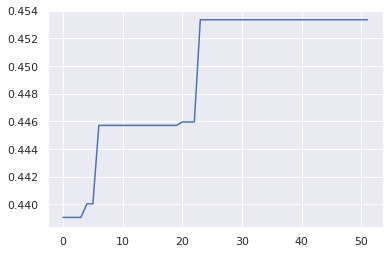

In [ ]:
plt.plot(max_accuracies)
plt.title('Accuracies through Evolution')
plt.xlabel()
plt.ylabel()
plt.show()

In [ ]:
#np.save('')
'''
np.save(os.path.join("/content/gdrive/MyDrive/Data", 'curr_accuracies.npy'), accuracies)
np.save(os.path.join("/content/gdrive/MyDrive/Data", 'curr_indices.npy'), indices)
np.save(os.path.join("/content/gdrive/MyDrive/Data", 'max_accuracies.npy'), max_accuracies)
'''

In [ ]:
accuracies = np.load(os.path.join("/content/gdrive/MyDrive/Data", 'curr_accuracies.npy'))
indices = np.load(os.path.join("/content/gdrive/MyDrive/Data", 'curr_indices.npy'))
max_accuracies = np.load(os.path.join("/content/gdrive/MyDrive/Data", 'max_accuracies.npy'))
a = list(max_accuracies)
a.insert(0, 0.41543513536453247)
a.insert(0, 0.3776683211326599)
a.insert(0, 0.3530377745628357)

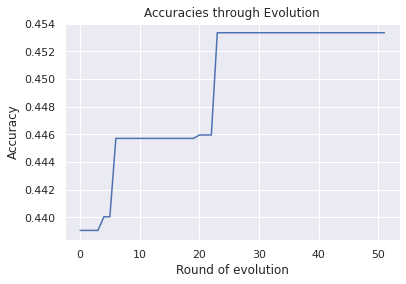

In [ ]:
plt.plot(max_accuracies)
plt.title('Accuracies through Evolution')
plt.xlabel('Round of evolution')
plt.ylabel('Accuracy')
plt.show()

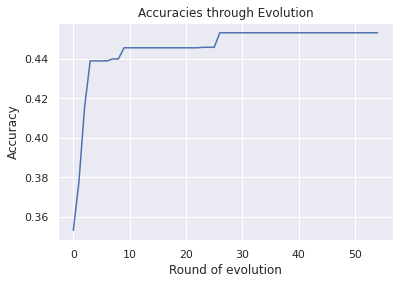

In [ ]:
plt.plot(a)
plt.title('Accuracies through Evolution')
plt.xlabel('Round of evolution')
plt.ylabel('Accuracy')
plt.show()